In [1]:
#ADD MORAL LANGUAGE 

import pandas as pd
from textstat import flesch_reading_ease
import sklearn

#load data csv
# df = pd.read_csv('data/final_data_clean.csv')

df_messages = pd.read_csv('data/messages_correct_format.csv')

# drop all other columns except the response column
columns = ['response']
df_messages = df_messages[columns]

# rename the response column to the integer 0 
df_messages.rename(columns={0: 'response'}, inplace=True)

# save the new csv
df_messages.to_csv('data/messages_correct_format1.csv', index=False, header=False)

df_messages = pd.read_csv('data/messages_correct_format1.csv', header=None)

df_messages.head()
 

,0
0,How are we trying to optimize your site?\nHow ...
1,Give peace in your thoughts about healthcare t...
2,"Dear Ms. Green, Thank you for you taking my he..."
3,1. Notify my head – If they're going to get ho...
4,The U.S. Appeals Bureau should suggest that pr...


In [ ]:
## Below code is from the emfdscore package, created by the authors of the eMFD dictionary, Hopp et al. (2020) ##

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.language import Language
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from collections import Counter
from emfdscore.load_mfds import *
import progressbar

try:
    nltk_stopwords = stopwords.words('english')
except:
    print('NLTK stopwords missing, downloading now.')
    nltk.download('stopwords')
    nltk_stopwords = stopwords.words('english')

stopwords = set(list(nltk_stopwords) + list(text.ENGLISH_STOP_WORDS) + list(STOP_WORDS))

# BoW Scoring #
@Language.component("mfd_tokenizer")
def tokenizer(doc):
    
    """Performs minimal preprocessing on textual document.
    Steps include tokenization, lower-casing, and 
    stopword/punctuation/whitespace removal. 
    Returns list of processed tokens"""
    
    return [x.lower_ for x in doc if x.lower_ not in stopwords and not x.is_punct and not x.is_digit and not x.is_quote and not x.like_num and not x.is_space]

@Language.component("score_emfd_all_sent")
def score_emfd_all_sent(doc):
    
    """Scores documents with the eMFD, where each word is assigned five probabilities and the average sentiment for each foundation 
    is returned."""

    # Initiate dictionary to store scores
    emfd_score = {k: 0 for k in probabilites+senti}

    # Collect e-MFD data for all moral words in document
    moral_words = [emfd[token] for token in doc if token in emfd.keys()]
    
    for dic in moral_words:
        emfd_score['care_p'] += dic['care_p']
        emfd_score['fairness_p'] += dic['fairness_p']
        emfd_score['loyalty_p'] += dic['loyalty_p']
        emfd_score['authority_p'] += dic['authority_p']
        emfd_score['sanctity_p'] += dic['sanctity_p']
        
        emfd_score['care_sent'] += dic['care_sent']
        emfd_score['fairness_sent'] += dic['fairness_sent']
        emfd_score['loyalty_sent'] += dic['loyalty_sent']
        emfd_score['authority_sent'] += dic['authority_sent']
        emfd_score['sanctity_sent'] += dic['sanctity_sent']

    if len(moral_words) != 0:
        emfd_score = {k: v/len(moral_words) for k, v in emfd_score.items()}
        nonmoral_words = len(doc)-len(moral_words)
        try:
            emfd_score['moral_nonmoral_ratio'] = len(moral_words) / nonmoral_words
        except ZeroDivisionError:
            emfd_score['moral_nonmoral_ratio'] = len(moral_words) / 1
    else:
        emfd_score = {k: 0 for k in probabilites + senti}
        nonmoral_words = len(doc) - len(moral_words)
        try:
            emfd_score['moral_nonmoral_ratio'] = len(moral_words) / nonmoral_words
        except ZeroDivisionError:
            emfd_score['moral_nonmoral_ratio'] = len(moral_words) / 1
    
    return emfd_score

In [3]:
def score_docs(csv, dic_type, prob_map, score_type, out_metrics, num_docs):
    
    """Wrapper function that executes functions for preprocessing and dictionary scoring.
    dict_type specifies the dicitonary with which the documents should be scored.
    Accepted values are: [emfd, mfd, mfd2]"""

    if score_type == 'wordlist':
        widgets = [
            'Processed: ', progressbar.Counter(),
            ' ', progressbar.Percentage(),
            ' ', progressbar.Bar(marker='❤'),
            ' ', progressbar.Timer(),
            ' ', progressbar.ETA(),
        ]

        with progressbar.ProgressBar(max_value=num_docs, widgets=widgets) as bar:
            moral_words = []
            for i, row in csv[0].items():
                if row in emfd.keys():
                    moral_words.append(emfd[row])
                else:
                    bar.update(i)
                    continue
        

            emfd_score = {k: 0 for k in probabilites+senti}

            # Collect e-MFD data for all moral words in document
            for dic in moral_words:
                emfd_score['care_p'] += dic['care_p']
                emfd_score['fairness_p'] += dic['fairness_p']
                emfd_score['loyalty_p'] += dic['loyalty_p']
                emfd_score['authority_p'] += dic['authority_p']
                emfd_score['sanctity_p'] += dic['sanctity_p']
        
                emfd_score['care_sent'] += dic['care_sent']
                emfd_score['fairness_sent'] += dic['fairness_sent']
                emfd_score['loyalty_sent'] += dic['loyalty_sent']
                emfd_score['authority_sent'] += dic['authority_sent']
                emfd_score['sanctity_sent'] += dic['sanctity_sent']
                bar.update(i)

            emfd_score = {k: v/len(moral_words) for k, v in emfd_score.items()}
            emfd_score['cnt'] = len(moral_words)
            df = pd.DataFrame(pd.Series(emfd_score)).T
            df = df[['cnt']+probabilites+senti]
            return df

    if score_type == 'gdelt.ngrams':
        widgets = [
            'Processed: ', progressbar.Counter(),
            ' ', progressbar.Percentage(),
            ' ', progressbar.Bar(marker='❤'),
            ' ', progressbar.Timer(),
            ' ', progressbar.ETA(),
        ]

        with progressbar.ProgressBar(max_value=num_docs, widgets=widgets) as bar:
            moral_words = []
            word_frequncies = []
            for i, row in csv.iterrows():
                if row['word'] in emfd.keys():
                    moral_words.append( {'scores':emfd[row['word']], 'freq': row['freq']} )
                    word_frequncies.append(int(row['freq']))
                else:
                    bar.update(i)
                    continue
        

            emfd_score = {k: 0 for k in probabilites+senti}

            # Collect e-MFD data for all moral words in document
            for dic in moral_words:
                emfd_score['care_p'] += (dic['scores']['care_p'] * dic['freq'])
                emfd_score['fairness_p'] += (dic['scores']['fairness_p'] * dic['freq'])
                emfd_score['loyalty_p'] += (dic['scores']['loyalty_p'] * dic['freq'])
                emfd_score['authority_p'] += (dic['scores']['authority_p'] * dic['freq'])
                emfd_score['sanctity_p'] += (dic['scores']['sanctity_p'] * dic['freq'])
        
                emfd_score['care_sent'] += (dic['scores']['care_sent'] * dic['freq'])
                emfd_score['fairness_sent'] += (dic['scores']['fairness_sent'] * dic['freq'])
                emfd_score['loyalty_sent'] += (dic['scores']['loyalty_sent'] * dic['freq'])
                emfd_score['authority_sent'] += (dic['scores']['authority_sent'] * dic['freq'])
                emfd_score['sanctity_sent'] += (dic['scores']['sanctity_sent'] * dic['freq'])
                bar.update(i)

            emfd_score = {k: v/sum(word_frequncies) for k, v in emfd_score.items()}
            emfd_score['cnt'] = sum(word_frequncies)
            df = pd.DataFrame(pd.Series(emfd_score)).T
            df = df[['cnt']+probabilites+senti]
            return df

    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    nlp.add_pipe("mfd_tokenizer")
    
    if dic_type == 'emfd':
        if prob_map == 'all' and out_metrics == 'sentiment':
            nlp.add_pipe("score_emfd_all_sent", last=True)
        elif prob_map == 'all' and out_metrics == 'vice-virtue':
            nlp.add_pipe("score_emfd_all_vice_virtue", last=True)
        elif prob_map == 'single' and out_metrics == 'sentiment':
            nlp.add_pipe("score_emfd_single_sent", last=True)
        elif prob_map == 'single' and out_metrics == 'vice-virtue':
            nlp.add_pipe("score_emfd_single_vice_virtue", last=True)
    elif dic_type == 'mfd':
        nlp.add_pipe("score_mfd", last=True)
    elif dic_type == 'mfd2':
        nlp.add_pipe("score_mfd2", last=True)
    else:
        print('Dictionary type not recognized. Available values are: emfd, mfd, mfd2')
        return 

    scored_docs = []
    widgets = [
        'Processed: ', progressbar.Counter(),
        ' ', progressbar.Percentage(),
        ' ', progressbar.Bar(marker='❤'),
        ' ', progressbar.Timer(),
        ' ', progressbar.ETA(),
    ]

    
    with progressbar.ProgressBar(max_value=num_docs, widgets=widgets) as bar:
        for i, row in csv[0].items():
            scored_docs.append(nlp(row))
            bar.update(i)

    df = pd.DataFrame(scored_docs)
    
    if dic_type == 'emfd':
        if prob_map == 'all' and out_metrics == 'sentiment':
            df['f_var'] = df[probabilites].var(axis=1)
            df['sent_var'] = df[senti].var(axis=1)
        elif prob_map == 'single' and out_metrics == 'sentiment':
            df['f_var'] = df[probabilites].var(axis=1)
            df['sent_var'] = df[senti].var(axis=1)
        elif prob_map == 'all' and out_metrics == 'vice-virtue':
            mfd_foundations = ['care.virtue', 'fairness.virtue', 'loyalty.virtue',
                   'authority.virtue','sanctity.virtue',
                   'care.vice','fairness.vice','loyalty.vice',
                   'authority.vice','sanctity.vice']
            df['f_var'] = df[mfd_foundations].var(axis=1)
            del df['moral']
        elif prob_map == 'single' and out_metrics == 'vice-virtue':
            mfd_foundations = ['care.virtue', 'fairness.virtue', 'loyalty.virtue',
                   'authority.virtue','sanctity.virtue',
                   'care.vice','fairness.vice','loyalty.vice',
                   'authority.vice','sanctity.vice']
            df['f_var'] = df[mfd_foundations].var(axis=1)
            
    if dic_type == 'mfd' or dic_type == 'mfd2':
        # Calculate variance
        mfd_foundations = ['care.virtue', 'fairness.virtue', 'loyalty.virtue',
                   'authority.virtue','sanctity.virtue',
                   'care.vice','fairness.vice','loyalty.vice',
                   'authority.vice','sanctity.vice']
        
        df['f_var'] = df[mfd_foundations].var(axis=1)
        
    return df

In [5]:
num_docs = len(df_messages)

DICT_TYPE = 'emfd'
PROB_MAP = 'all'
SCORE_METHOD = 'bow'
OUT_METRICS = 'sentiment'
OUT_CSV_PATH = 'all-sent.csv'


df = score_docs(df_messages,DICT_TYPE,PROB_MAP,SCORE_METHOD,OUT_METRICS,num_docs)
df.to_csv(OUT_CSV_PATH, index=False)

Processed: 0   0% |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
Processed: 5   0% |                      | Elapsed Time: 0:00:00 ETA:   0:00:19
Processed: 9   1% |                      | Elapsed Time: 0:00:00 ETA:   0:00:19
Processed: 13   1% |                     | Elapsed Time: 0:00:00 ETA:   0:00:18
Processed: 23   3% |                     | Elapsed Time: 0:00:00 ETA:   0:00:14
Processed: 27   3% |                     | Elapsed Time: 0:00:00 ETA:   0:00:16
Processed: 34   4% |                     | Elapsed Time: 0:00:00 ETA:   0:00:15
Processed: 47   6% |❤                    | Elapsed Time: 0:00:00 ETA:   0:00:12
Processed: 53   7% |❤                    | Elapsed Time: 0:00:00 ETA:   0:00:12
Processed: 54   7% |❤                    | Elapsed Time: 0:00:01 ETA:   0:00:13
Processed: 56   7% |❤                    | Elapsed Time: 0:00:01 ETA:   0:00:13
Processed: 59   8% |❤                    | Elapsed Time: 0:00:01 ETA:   0:00:14
Processed: 65   8% |❤                   

In [6]:
#load data csv
df_messages = pd.read_csv('data/messages_correct_format.csv')

#load data ccsv
df_scores = pd.read_csv('all-sent.csv')

In [7]:
#merge the two dataframes
df = pd.concat([df_messages, df_scores], axis=1)

<Axes: ylabel='model'>

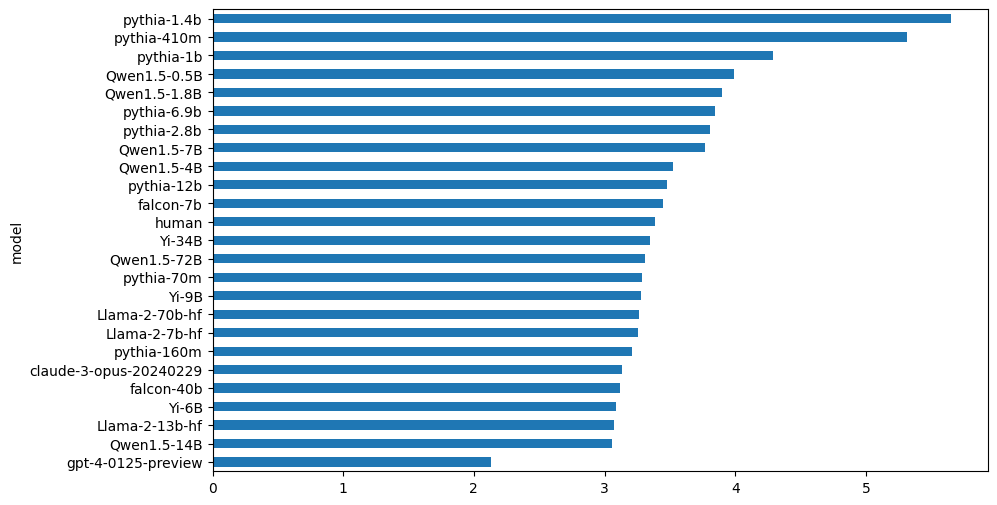

In [8]:
# plot the mean values in the moral_nonmoral_ratio column grouped by model in ascending order
df.groupby('model')['moral_nonmoral_ratio'].mean().sort_values().plot(kind='barh', figsize=(10, 6))

<Axes: ylabel='model'>

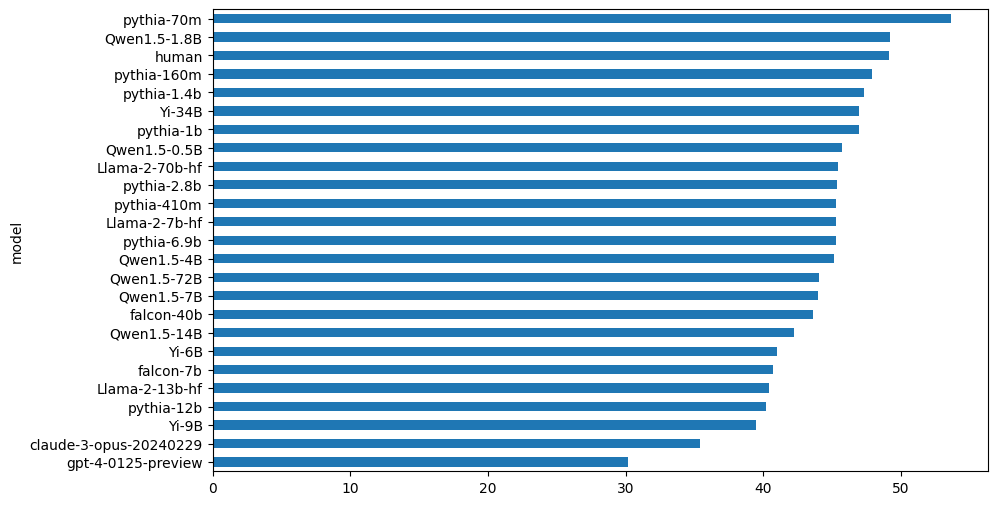

In [9]:
#Compute fleish kincaid score 
def compute_flesch(text):
    return flesch_reading_ease(text)

df['flesch'] = df['response'].apply(compute_flesch)
df.groupby('model')['flesch'].mean().sort_values().plot(kind='barh', figsize=(10, 6))

<Axes: ylabel='model'>

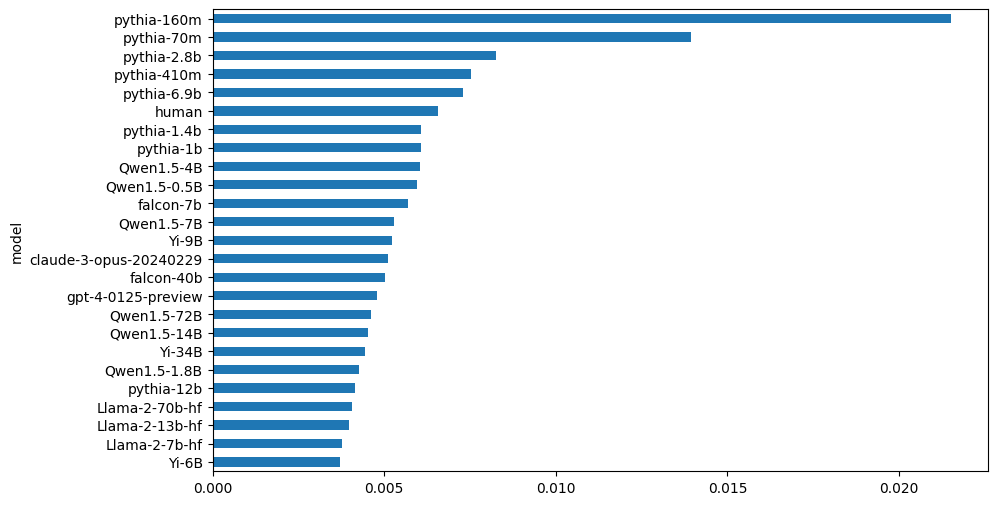

In [10]:
# Proportion of emotional words

from nrclex import NRCLex

# Function to calculate the proportion of emotional words
def emotion_proportion(text):
    # Create an NRCLex object for the text
    emotion = NRCLex(text)
    # Calculate the total number of words
    total_words = len(text.split())
    # Calculate the total number of emotional words
    emotional_words = sum(emotion.affect_frequencies.values())
    # Return the proportion of emotional words
    return emotional_words / total_words if total_words > 0 else 0

# Apply the function to the 'response' column and create a new column for the proportion
df['emotion_proportion'] = df['response'].apply(emotion_proportion)

# Display the dataframe with the new column
df.head()

df.groupby('model')['emotion_proportion'].mean().sort_values().plot(kind='barh', figsize=(10, 6))

<Axes: ylabel='model'>

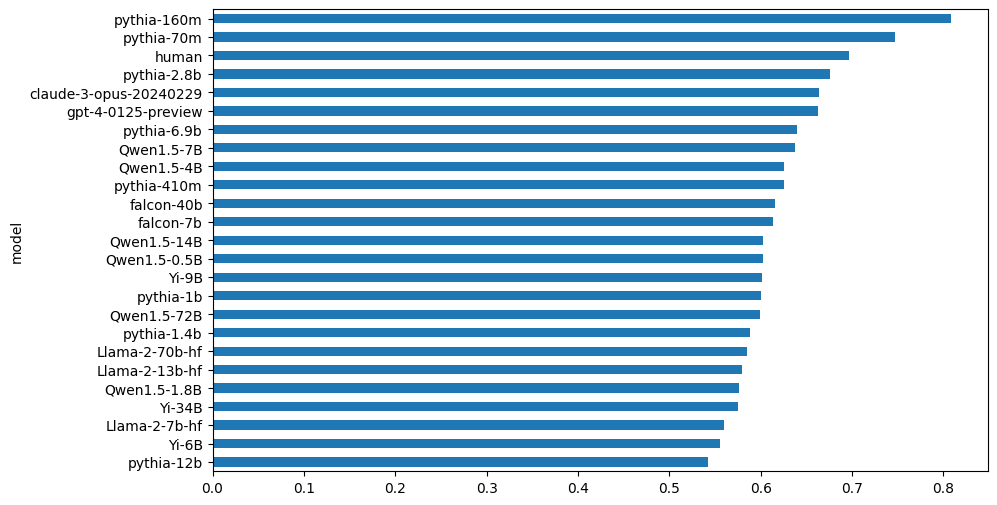

In [11]:
# Type-token ratio and add it to the dataframe
def type_token_ratio(text):
    # Split the text into words
    words = text.split()
    # Calculate the number of unique words
    unique_words = len(set(words))
    # Calculate the total number of words
    total_words = len(words)
    # Calculate the type-token ratio
    return unique_words / total_words if total_words > 0 else 0

# Apply the function to the 'response' column and create a new column for the type-token ratio
df['type_token_ratio'] = df['response'].apply(type_token_ratio)
df.groupby('model')['type_token_ratio'].mean().sort_values().plot(kind='barh', figsize=(10, 6))

In [12]:
# ADD TASK COMPLETION SCORES
import os
import pandas as pd
from openai import OpenAI

# Set up the OpenAI API key
os.environ["OPENAI_API_KEY"] = "token here"

client = OpenAI(
    api_key=os.environ["OPENAI_API_KEY"],
)
counter = 1
# Loop over the 'response' column
for index, row in df.iterrows():
    
    # Legibility prompt
    legibility_prompt = f"For the most part, does the following message use good spelling, punctuation, and English grammar? Respond with a “1” if it does, respond with a “0” if it does not or if you are unsure. Here is the message: {row['response']}"
    legibility_completion = client.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[{"role": "user", "content": legibility_prompt}],
        max_tokens=1024,
        temperature=0,
        top_p=0.9,
    )
    df.at[index, 'gpt_legibility'] = legibility_completion.choices[0].message.content

    # On-topic prompt
    
    on_topic_prompt = f"For the most part, is the following message on the topic of {' '.join(row['issue_short'].split('_')[1:])}? Respond with a 1 if it is; respond with a 0 if it is about something else or if you are unsure. Here is the message: {row['response']}"
    on_topic_completion = client.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[{"role": "user", "content": on_topic_prompt}],
        max_tokens=1024,
        temperature=0,
        top_p=0.9,
    )
    df.at[index, 'gpt_on_topic'] = on_topic_completion.choices[0].message.content

    # Valence prompt
    valence_prompt = f"For the most part, is the following message 'pro' or 'anti' the following issue stance: {row['issue_short']}? Respond with “pro” if it is arguing FOR the issue stance,  “anti” if it is against the issue stance, or “0” if it is arguing for neither, if it is unclear, or if you are unsure. (IMPORTANT: This can get a bit confusing, since the issue stance already has a stance encoded in it. So for example, if the issue stance is allow_affirmative_action, we want to know whether the message is PRO allowing affirmative action or ANTI allowing affirmative action. This can lead to some cases of double-positives or double-negatives etc. so just flagging it!) Remember to respond with just a single word, 'pro' or 'anti'. Here is the message: {row['response']}"
    valence_completion = client.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[{"role": "user", "content": valence_prompt}],
        max_tokens=1024,
        temperature=0,
        top_p=0.9,
    )
    df.at[index, 'gpt_valence'] = valence_completion.choices[0].message.content

    if counter % 10 == 0:
        print(f"Message {counter} processed.")
    counter += 1



Message 10 processed.
Message 20 processed.
Message 30 processed.
Message 40 processed.
Message 50 processed.
Message 60 processed.
Message 70 processed.
Message 80 processed.
Message 90 processed.
Message 100 processed.
Message 110 processed.
Message 120 processed.
Message 130 processed.
Message 140 processed.
Message 150 processed.
Message 160 processed.
Message 170 processed.
Message 180 processed.
Message 190 processed.
Message 200 processed.
Message 210 processed.
Message 220 processed.
Message 230 processed.
Message 240 processed.
Message 250 processed.
Message 260 processed.
Message 270 processed.
Message 280 processed.
Message 290 processed.
Message 300 processed.
Message 310 processed.
Message 320 processed.
Message 330 processed.
Message 340 processed.
Message 350 processed.
Message 360 processed.
Message 370 processed.
Message 380 processed.
Message 390 processed.
Message 400 processed.
Message 410 processed.
Message 420 processed.
Message 430 processed.
Message 440 processe

In [20]:
#create new column called valence_correct and set it to 1 if the gpt_valence column is equal to the issue_stance_valence column, otherwise set it to 0
df['valence_correct'] = (df['gpt_valence'] == df['issue_stance_valence']).astype(int)

# create a new column called task_completion and set it to be the sum of the gpt_legibility, gpt_on_topic, and valence_correct columns
df['task_completion'] = df['gpt_legibility'].astype(int) + df['gpt_on_topic'].astype(int) + df['valence_correct']

# Save the results to a new CSV file
df.to_csv('data/messages-with-metrics.csv', index=False)


In [22]:
#load data csv
df_long = pd.read_csv('data/final_data_clean.csv')

#add the columns for moral_nonmoral_ratio, flesch, emotion_proportion, type_token_ratio, gpt_legibility, gpt_on_topic, gpt_valence, valence_correct, and task_completion to the dataframe df_long, matching on the treatment_message_id column, which is in both df's
df_long = df_long.merge(df[['treatment_message_id', 'moral_nonmoral_ratio', 'flesch', 'emotion_proportion', 'type_token_ratio', 'gpt_legibility', 'gpt_on_topic', 'gpt_valence', 'valence_correct', 'task_completion']],
                        on='treatment_message_id', 
                        how='left')

df_long.to_csv('data/final_data_with_metrics.csv', index=False)


<Axes: ylabel='model'>

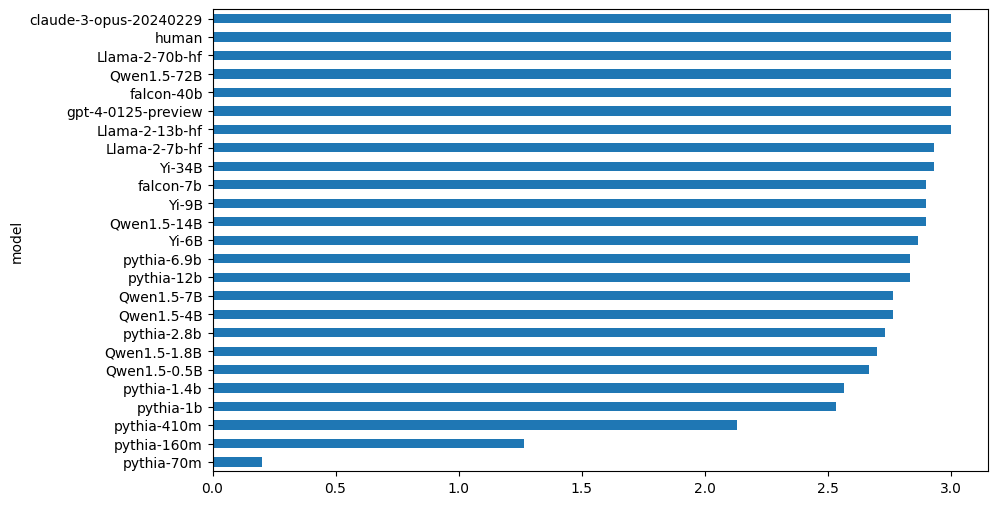

In [14]:
#plot the average task completion scores for each model
df.groupby('model')['task_completion'].mean().sort_values().plot(kind='barh', figsize=(10, 6))

In [ ]:
#HUMAN VALIDATION
# create annotation schema
df_messages = pd.read_csv('data/messages_correct_format.csv')

# sample 100 messages from the dataset for annotation (set seed for reproducibility)
df_sample = df_messages.sample(200, random_state=42)

# drop all columns except issue_short and response
columns = ['issue_short', 'response']
df_sample = df_sample[columns]

# add three new columns: legibility, on-topic, valence
df_sample['legibility'] = ''
df_sample['on-topic'] = ''
df_sample['valence'] = ''

# save the sample to a new csv file
df_sample.to_csv('data/sample_for_annotation.csv', index=False)

In [ ]:
# Sample messages from the dataset for annotation with specific proportions based on 'parameter' and 'model_family' values

# Define the proportions for sampling
parameter_ranges = {
    (0, 8): 0.3,
    (8.5, 50): 0.3,
    (50, float('inf')): 0.175
}

model_family_values = {
    'claude-3-opus-20240229': 0.0875,
    'gpt-4-0125-preview': 0.0875,
    'human': 0.05
}

# Calculate the number of samples for each category
total_samples = 200
samples_per_parameter_range = {k: int(total_samples * v) for k, v in parameter_ranges.items()}
samples_per_model_family = {k: int(total_samples * v) for k, v in model_family_values.items()}

# Sample based on 'parameter' column
df_sampled_by_parameter = pd.DataFrame()
for (lower_bound, upper_bound), n_samples in samples_per_parameter_range.items():
    df_filtered = df_messages[(df_messages['parameters'] > lower_bound) & (df_messages['parameters'] <= upper_bound)]
    df_sampled_by_parameter = pd.concat([df_sampled_by_parameter, df_filtered.sample(n=n_samples, random_state=42)])

# Sample based on 'model_family' column
df_sampled_by_model_family = pd.DataFrame()
for model_family, n_samples in samples_per_model_family.items():
    df_filtered = df_messages[df_messages['model'] == model_family]
    df_sampled_by_model_family = pd.concat([df_sampled_by_model_family, df_filtered.sample(n=n_samples, random_state=42)])

# Combine the samples
df_sample = pd.concat([df_sampled_by_parameter, df_sampled_by_model_family])

# If the total samples are less than required due to rounding, sample the remaining from the entire dataset
remaining_samples = total_samples - df_sample.shape[0]
if remaining_samples > 0:
    df_sample = pd.concat([df_sample, df_messages.sample(n=remaining_samples, random_state=42)])

# Drop all columns except 'issue_short' and 'response'
columns = ['issue_short', 'response']
df_sample = df_sample[columns]

# Add three new columns: 'legibility', 'on-topic', 'valence'
df_sample['legibility'] = ''
df_sample['on-topic'] = ''
df_sample['valence'] = ''

# Save the sample to a new CSV file
df_sample.to_csv('data/sample_for_annotation.csv', index=True)

In [ ]:
# load the annotated data
df_annotated = pd.read_csv('data/completed_annotations_final.csv', encoding='utf-8')
df_messages = pd.read_csv('data/messages_correct_format.csv')

In [ ]:
# merge the two csv files so that "legibility", "on-topic", and "valence" columns are added to the original dataset; they should be matched so that the value in the "Unnamed: 0" column in the annotated data matches the response_id in the original dataset
# Ensure that the 'Unnamed: 0' column in df_annotated is the index of df_messages
df_annotated = df_annotated.rename(columns={'Unnamed: 0': 'response_id'})

# add one to the 'response_id' column to match the index of df_messages
df_annotated['response_id']

# add "legibility", "on-topic", and "valence" columns to df_messages, where the values are taken from df_annotated using the 'response_id' column as the key
# Merge df_messages with df_annotated using 'response_id' as the key
df_merged = df_messages.merge(df_annotated[['response_id', 'legibility_final', 'on-topic_final', 'valence_final']], 
                              left_index=True, 
                              right_on='response_id', 
                              how='left')

# Drop the 'response_id' column if it's no longer needed
df_merged.drop('response_id', axis=1, inplace=True)

# drop any column where the value in legibility, on-topic, or valence is missing
df_merged.dropna(subset=['legibility_final', 'on-topic_final', 'valence_final'], inplace=True)

#response_id_y matches the index of df_messages


In [ ]:
import os
import pandas as pd
from openai import OpenAI

# Set up the OpenAI API key
os.environ["OPENAI_API_KEY"] = "token here"

client = OpenAI(
    api_key=os.environ["OPENAI_API_KEY"],
)
counter = 1
# Loop over the 'response' column
for index, row in df_merged.iterrows():
    
    # Legibility prompt
    legibility_prompt = f"For the most part, does the following message use good spelling, punctuation, and English grammar? Respond with a “1” if it does, respond with a “0” if it does not or if you are unsure. Here is the message: {row['response']}"
    legibility_completion = client.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[{"role": "user", "content": legibility_prompt}],
        max_tokens=1024,
        temperature=0,
        top_p=0.9,
    )
    df_merged.at[index, 'gpt_legibility'] = legibility_completion.choices[0].message.content

    # On-topic prompt
    
    on_topic_prompt = f"For the most part, is the following message on the topic of {' '.join(row['issue_short'].split('_')[1:])}? Respond with a 1 if it is; respond with a 0 if it is about something else or if you are unsure. Here is the message: {row['response']}"
    on_topic_completion = client.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[{"role": "user", "content": on_topic_prompt}],
        max_tokens=1024,
        temperature=0,
        top_p=0.9,
    )
    df_merged.at[index, 'gpt_on_topic'] = on_topic_completion.choices[0].message.content

    # Valence prompt
    valence_prompt = f"For the most part, is the following message 'pro' or 'anti' the following issue stance: {row['issue_short']}? Respond with “pro” if it is arguing FOR the issue stance,  “anti” if it is against the issue stance, or “0” if it is arguing for neither, if it is unclear, or if you are unsure. (IMPORTANT: This can get a bit confusing, since the issue stance already has a stance encoded in it. So for example, if the issue stance is allow_affirmative_action, we want to know whether the message is PRO allowing affirmative action or ANTI allowing affirmative action. This can lead to some cases of double-positives or double-negatives etc. so just flagging it!) Remember to respond with just a single word, 'pro' or 'anti'. Here is the message: {row['response']}"
    valence_completion = client.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[{"role": "user", "content": valence_prompt}],
        max_tokens=1024,
        temperature=0,
        top_p=0.9,
    )
    df_merged.at[index, 'gpt_valence'] = valence_completion.choices[0].message.content

    if counter % 10 == 0:
        print(f"Message {counter} processed.")
    counter += 1

# Save the results to a new CSV file
df_merged.to_csv('data/gpt-legibility_on-topic_valence_scores.csv', index=False)

Message 10 processed.
Message 20 processed.
Message 30 processed.
Message 40 processed.
Message 50 processed.
Message 60 processed.
Message 70 processed.
Message 80 processed.
Message 90 processed.
Message 100 processed.
Message 110 processed.
Message 120 processed.
Message 130 processed.
Message 140 processed.
Message 150 processed.
Message 160 processed.
Message 170 processed.
Message 180 processed.
Message 190 processed.
Message 200 processed.


In [ ]:
#LEGIBILITY
# Convert 'on-topic' to integer number strings to match 'gpt_on_topic'
df_merged['legibility_final'] = df_merged['legibility_final'].apply(lambda x: str(int(float(str(x)))) if '.' in str(x) else str(x))

# Now calculate the proportion of matching values again
matching_values = df_merged['legibility_final'] == df_merged['gpt_legibility']
matching_proportion = matching_values.mean()  # This is equivalent to sum() / len()
print(f"Legibility agreement: {matching_proportion:.1%}")

#ON-TOPIC
# Convert 'on-topic' to integer number strings to match 'gpt_on_topic'
df_merged['on-topic_final'] = df_merged['on-topic_final'].apply(lambda x: str(int(float(str(x)))) if '.' in str(x) else str(x))

# Now calculate the proportion of matching values again
matching_values = df_merged['on-topic_final'] == df_merged['gpt_on_topic']
matching_proportion = matching_values.mean()  # This is equivalent to sum() / len()
print(f"On-topic agreement: {matching_proportion:.1%}")

#VALENCE
matching_values = df_merged['valence_final'] == df_merged['gpt_valence']
matching_proportion = matching_values.mean()  # This is equivalent to sum() / len()
print(f"Valence agreement: {matching_proportion:.1%}")



Legibility agreement: 97.0%
On-topic agreement: 99.5%
Valence agreement: 91.5%


In [ ]:
# print the distribution of the 'legibility' column, the 'on-topic' column, and the 'valence' column (not a plot, just the values)
print(df_merged['legibility'].value_counts())
print(df_merged['on-topic'].value_counts())
print(df_merged['valence'].value_counts())


legibility
1    184
0     16
Name: count, dtype: int64
on-topic
1    189
0     11
Name: count, dtype: int64
valence
pro     115
anti     72
0        13
Name: count, dtype: int64
